In [1]:
import os
import sys
import csv
import json
import warnings
import argparse
import numpy as np
import pandas as pd
import shap as shap_module

from types import SimpleNamespace

from config.model import model_finalize
from util.io import *

from util.measure import performance_score, fariness_score
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
import pickle

In [2]:
# select the outcome dataset
current_lable = 'cp1+cp2+hsr'#'case_CP1_flag','case_CP2_flag','case_HSR_flag'
# select the save path
save = 'trained_model_resutls'

In [3]:
features, label = clean_raw_data(f'Preprocessed/absolute_control/1_year/match_cohort_baseline_1year_target_{current_lable}.csv')
X_dict = {}
Y_dict = {}
os.makedirs(save, exist_ok=True)
for mpec_test in ['whole', 'smaller_threshold', 'larger_threshold']:
    if mpec_test == 'whole':
        temp_features, temp_label = features, label
        pd.concat([temp_features, temp_label], axis = 1).drop(columns=['mpec']).to_csv(f'{save}/1year_{current_lable}_l+h.csv')
    elif mpec_test == 'smaller_threshold':
        temp_features = features[features.mpec <= 0.3]
        temp_label = label.iloc[temp_features.index]
        pd.concat([temp_features, temp_label], axis = 1).drop(columns=['mpec']).to_csv(f'{save}/1year_{current_lable}_l.csv')
    else:
        temp_features = features[features.mpec > 0.3]
        temp_label = label.iloc[temp_features.index]
        pd.concat([temp_features, temp_label], axis = 1).drop(columns=['mpec']).to_csv(f'{save}/1year_{current_lable}_h.csv')
    temp_features, temp_label = temp_features.reset_index(drop=True).drop(columns=['mpec']), temp_label.reset_index(drop=True)
    target = temp_label[current_lable]
    
    # print('original target: ', target.value_counts())
    less = target[target == target.value_counts().sort_values(ascending=True).index.to_list()[0]]
    more = target[target == target.value_counts().sort_values(ascending=True).index.to_list()[1]].sample(n=len(less), random_state=42)
    Y = pd.concat([less,more])
    X = temp_features.iloc[Y.index]
    original_cols = X.columns
    # print('y shape: ', Y.shape)
    # print(Y.value_counts())
    # print('x shape: ', X.shape)

    X_dict[mpec_test] = X
    Y_dict[mpec_test] = Y
model_path = f'trained_Models/absolute_control/whole/xgboost/1_year/absolute_control_xgboost_1_yearyear_{current_lable}.pkl'

with open(model_path, 'rb') as f:
    cfg = pickle.load(f)


/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:05:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_

              precision    recall  f1-score   support

           0       0.97      0.81      0.88        47
           1       0.84      0.98      0.90        47

    accuracy                           0.89        94
   macro avg       0.91      0.89      0.89        94
weighted avg       0.91      0.89      0.89        94



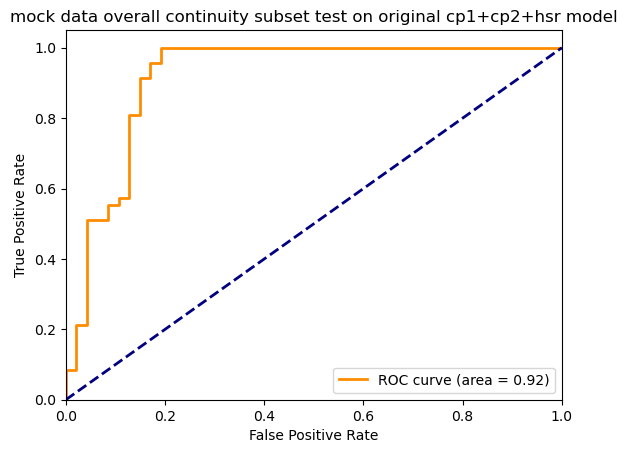

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        31
           1       0.91      0.97      0.94        31

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



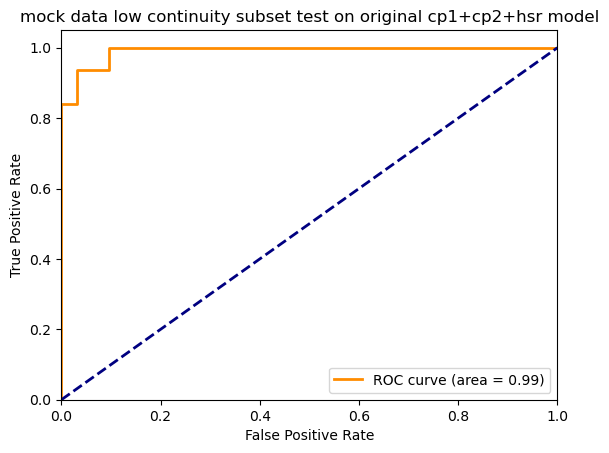

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12



/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/continuity_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

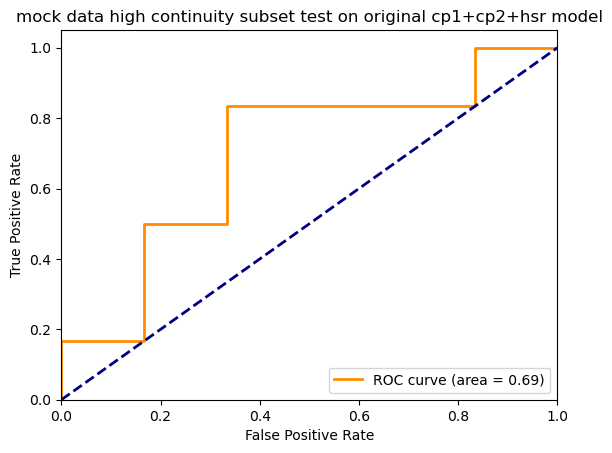

****************************************************************************************************


In [4]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for typ in ['whole', 'smaller_threshold', 'larger_threshold']:
    y_pred = cfg.predict(X_dict[typ].to_numpy())
    y_true = Y_dict[typ]
    report = classification_report(y_true, y_pred)
    print(report)
    y_pred_prob = cfg.predict_proba(X_dict[typ].to_numpy())[:, 1]  


    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if typ == 'whole':
        typ = 'overall continuity'
    elif typ == 'smaller_threshold':
        typ = 'low continuity'
    elif typ == 'larger_threshold':
        typ = 'high continuity'
    title = f'mock data {typ} subset test on original {current_lable} model'
    plt.title(title)
    plt.legend(loc='lower right')
    plt.savefig(f'{save}/'+title+'.png')
    plt.show()
    print('*'*100)